<a href="https://colab.research.google.com/github/GanesH2O/Downscale-GRACE/blob/main/02_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
#import cuml
#from cuml.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid, KFold
#import cudf
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_ori = pd.read_csv('/content/drive/MyDrive/Paperwork/RFM/TRAINING/G3S/RFM_training.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])
#columns_to_exclude = ['time', 'lat', 'lon','lwe_thickness']
#columns_to_normalize = df_ori.columns.difference(columns_to_exclude)
df = df_ori.dropna()
df

,time,y,x,gwsa,lst_day,lst_night,NDVI,EVI,population_density,precipitation,elevation,slope,aspect
4,2003-01-01,26.25,77.25,146.796998,27.019380,6.345727,0.238350,0.137750,166.0,0.022280,173,0.071327,181.967800
15,2003-01-01,26.25,77.75,135.320641,26.265158,7.731798,0.223150,0.149975,172.0,0.021599,194,0.095055,171.342440
16,2003-01-01,26.75,77.75,193.307228,21.747989,5.330973,0.530650,0.334175,351.0,0.020047,201,0.021416,123.211815
17,2003-01-01,27.25,77.75,245.828532,18.458446,6.728641,0.694375,0.460225,670.0,0.040350,175,0.023970,100.222170
18,2003-01-01,27.75,77.75,288.449101,18.148052,6.165229,0.654800,0.412200,584.0,0.053392,186,0.009851,47.121098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54629,2020-12-01,25.75,87.75,-96.570445,25.846292,12.160020,0.518725,0.318475,1154.0,0.000552,38,0.019397,171.977600
54630,2020-12-01,26.25,87.75,-103.741007,27.089382,12.387824,0.303975,0.179675,1005.0,0.002171,55,0.082164,349.148440
54631,2020-12-01,26.75,87.75,-107.392590,22.012795,12.520372,0.745450,0.387575,321.0,0.004165,226,1.095422,352.386660
54641,2020-12-01,26.25,88.25,-115.900829,28.357755,11.881191,0.403725,0.236000,750.0,0.002223,57,0.085156,5.995384


# Other models

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


# Define feature columns by dropping 'gwsa', 'x', 'y', 'time'
X = df.drop(['gwsa', 'x', 'y', 'time'], axis=1)
y = df['gwsa']

# Split the data into training and testing sets (80% train, 20% test)
# Note: For time-series data, consider splitting sequentially based on 'time'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Mean Squared Error
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}")

XGBoost MSE: 5051.058931740939


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:51:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [ ]:
# Calculate R²
r2 = r2_score(y_test, y_pred_xgb)

# Calculate KGE
# Pearson correlation coefficient (r)
correlation = np.corrcoef(y_test, y_pred_xgb)[0, 1]

# Ratio of standard deviations (alpha = std_pred / std_obs)
alpha = np.std(y_pred_xgb) / np.std(y_test)

# Ratio of means (beta = mean_pred / mean_obs)
beta = np.mean(y_pred_xgb) / np.mean(y_test)

# KGE formula: 1 - sqrt((r-1)^2 + (alpha-1)^2 + (beta-1)^2)
kge = 1 - np.sqrt((correlation - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

# Print R², NSE, and KGE
print(f"R² (Coefficient of Determination): {r2:.4f}")
print(f"NSE (Nash-Sutcliffe Efficiency): {r2:.4f}")
print(f"KGE (Kling-Gupta Efficiency): {kge:.4f}")
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}")

R² (Coefficient of Determination): 0.7111
NSE (Nash-Sutcliffe Efficiency): 0.7111
KGE (Kling-Gupta Efficiency): 0.7367
XGBoost MSE: 5051.058931740939


In [ ]:
joblib.dump(xgb_model, '/content/drive/MyDrive/Paperwork/RFM/G3S_xgboost_model.pkl')

print("XGBoost model exported successfully as xgboost_model.pkl")

XGBoost model exported successfully as xgboost_model.pkl


# Pearson Corelation

NameError: name 'save_path' is not defined

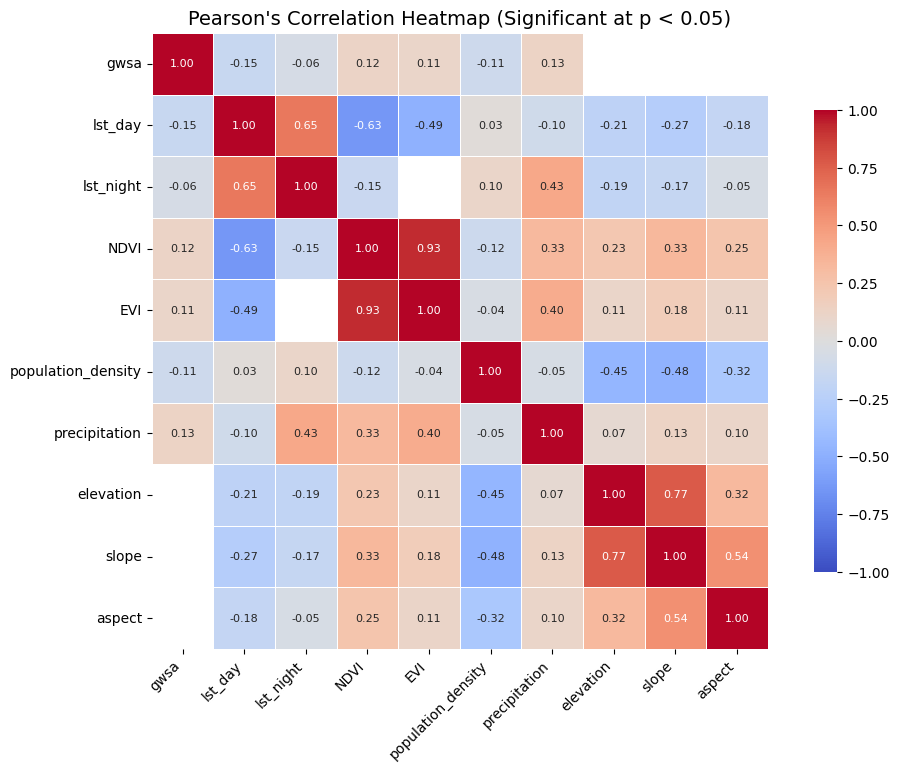

In [ ]:
# Function to calculate Pearson's correlation and p-values
def calculate_pearsonr(df):
    # Create empty DataFrames to store correlation and p-values
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    p_value_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

    # Loop through columns and calculate Pearson's correlation coefficient and p-values
    for col1 in df.columns:
        for col2 in df.columns:
            corr, p_value = pearsonr(df[col1], df[col2])
            corr_matrix.loc[col1, col2] = corr
            p_value_matrix.loc[col1, col2] = p_value

    # Convert to numeric type (floating point)
    corr_matrix = corr_matrix.astype(float)
    p_value_matrix = p_value_matrix.astype(float)

    return corr_matrix, p_value_matrix

# Exclude 'time', 'lat', 'lon', 'lwe_thickness' (if needed for visualization)
df_analysis = df.drop(columns=['time', 'x', 'y'])

# Calculate correlation and p-values
corr_matrix, p_value_matrix = calculate_pearsonr(df_analysis)

# Create a mask for significant correlations (p < 0.05)
significance_mask = p_value_matrix < 0.05

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=~significance_mask,
            square=True, linewidths=.5, vmin=-1, vmax=1, cbar_kws={"shrink": .75},
            annot_kws={"size": 8}, fmt=".2f")

# Set titles and labels
plt.title("Pearson's Correlation Heatmap (Significant at p < 0.05)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
#save_path = "/content/drive/My Drive/Thesis/RESULTS/GLDAS/correlation_heatmap.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
# Display the plot
plt.tight_layout()
plt.show()

# RFM

In [ ]:
#Important functions
def cal_rmse(model, actual):
  rmse = np.sqrt(mean_squared_error(actual, model))
  return rmse

def cal_nse(model, actual):
  nse = 1 - (np.sum(actual - model)**2 / np.sum((actual - np.mean(actual))**2))
  return nse

def cal_kge(actual, model):
  if np.std(actual) == 0 or np.mean(actual) == 0:
        # Return NA values for alpha, beta, and kge if standard deviation or mean of actual is zero
        return np.nan
  cc = np.corrcoef(actual, model)[0, 1]  # correlation coefficient
  alpha = np.std(model) / np.std(actual)  # ratio of the standard deviation
  beta = np.mean(model) / np.mean(actual)
  kge = 1 - np.sqrt((cc - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
  return kge

def cal_cc(actual, model):
  cc = np.corrcoef(actual, model)[0, 1]
  return cc

def cal_bias(actual, model):
  bias = np.mean(model - actual)
  return bias

In [ ]:
X = df.drop(['gwsa', 'x', 'y', 'time', 'elevation', 'lst_night'], axis=1)
y = df['gwsa']

X = X.astype(np.float32)  # Ensure float32
y = y.astype(np.float32)

# Convert to cuDF for GPU processing
X_cudf = cudf.DataFrame(X)
Y_cudf = cudf.Series(y)

# ------------------------------------------------------------------------------
# 2. Define the full parameter grid (same as before)
# ------------------------------------------------------------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 25, 30],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 0.5]
}

# ------------------------------------------------------------------------------
# 3. Build the full list of all possible combinations, then randomly sample n_iter
# ------------------------------------------------------------------------------
all_combinations = list(ParameterGrid(param_grid))
random.seed(42)           # for reproducibility
n_iter = 20               # number of random configurations you want to try

# If n_iter > total combos, just use all combos
if n_iter >= len(all_combinations):
    sampled_combinations = all_combinations.copy()
else:
    sampled_combinations = random.sample(all_combinations, n_iter)

# ------------------------------------------------------------------------------
# 4. Prepare output CSV (same as before)
# ------------------------------------------------------------------------------
output_file = '/content/drive/MyDrive/Paperwork/RFM/RESULTS/Random_forest_random_search_cuml_cv.csv'

if not os.path.exists(output_file):
    with open(output_file, 'w') as f:
        f.write('n_estimators,max_depth,min_samples_leaf,max_features,fold,NSE_train,KGE_train,NSE_val,KGE_val\n')

# ------------------------------------------------------------------------------
# 5. Cross‐validation settings
# ------------------------------------------------------------------------------
nfolds = 10
kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)

# ------------------------------------------------------------------------------
# 6. Iterate through each randomly sampled parameter set
# ------------------------------------------------------------------------------
for params in sampled_combinations:
    print(f"Processing parameter set: {params}")

    fold_idx = 1
    for train_index, val_index in kf.split(X_cudf.to_pandas()):
        # Split data
        X_train = X_cudf.iloc[train_index]
        X_val   = X_cudf.iloc[val_index]
        Y_train = Y_cudf.iloc[train_index]
        Y_val   = Y_cudf.iloc[val_index]

        # Train RF with cuML
        rf_model = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            random_state=42,
            n_streams=1
        )
        rf_model.fit(X_train, Y_train)

        # Predictions
        Y_train_pred = rf_model.predict(X_train)
        Y_val_pred   = rf_model.predict(X_val)

        # Metrics (convert to NumPy arrays for your functions)
        nse_train = cal_nse(Y_train_pred.to_numpy(), Y_train.to_numpy())
        kge_train = cal_kge(Y_train.to_numpy(), Y_train_pred.to_numpy())

        nse_val = cal_nse(Y_val_pred.to_numpy(), Y_val.to_numpy())
        kge_val = cal_kge(Y_val.to_numpy(), Y_val_pred.to_numpy())

        # Append to CSV
        with open(output_file, 'a') as f:
            f.write(
                f"{params['n_estimators']},{params['max_depth']},{params['min_samples_leaf']},"
                f"{params['max_features']},{fold_idx},{nse_train},{kge_train},{nse_val},{kge_val}\n"
            )

        fold_idx += 1

print("Random grid search complete. Results saved to:", output_file)

Processing parameter set: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 300}
Processing parameter set: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
Processing parameter set: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 300}
Processing parameter set: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 200}
Processing parameter set: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 200}
Processing parameter set: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 300}
Processing parameter set: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 200}
Processing parameter set: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 300}
Processing parameter set: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Processing param

In [ ]:
X = df.drop(['gwsa', 'x', 'y', 'time'], axis=1)
y = df['gwsa']

# Create a Random Forest Regressor object with predefined hyperparameters
rf_model = RandomForestRegressor()

# Initialize KFold with 10 splits and shuffling
kf = KFold(n_splits=10, shuffle=True)

# Perform cross-validation for MSE and R-squared
mse_scores = -cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')

# Print scores for each fold
for i, (mse, r2) in enumerate(zip(mse_scores, r2_scores)):
    print(f"Fold {i+1}: MSE = {mse:.4f}, R-squared = {r2:.4f}")

# Calculate and print the average scores
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)
print(f"\nAverage MSE across 10 folds: {average_mse:.4f}")
print(f"Average R-squared across 10 folds: {average_r2:.4f}")

Fold 1: MSE = 6539.2249, R-squared = 0.6117
Fold 2: MSE = 6684.5455, R-squared = 0.5911
Fold 3: MSE = 6437.4433, R-squared = 0.6123
Fold 4: MSE = 7071.5684, R-squared = 0.6143
Fold 5: MSE = 6816.4554, R-squared = 0.6318
Fold 6: MSE = 6550.4524, R-squared = 0.6177
Fold 7: MSE = 6191.5302, R-squared = 0.6370
Fold 8: MSE = 6419.2325, R-squared = 0.5956
Fold 9: MSE = 6817.7512, R-squared = 0.6105
Fold 10: MSE = 6612.0847, R-squared = 0.6071

Average MSE across 10 folds: 6614.0288
Average R-squared across 10 folds: 0.6129


In [ ]:
# Create a Random Forest Regressor object
rf_model = RandomForestRegressor(random_state=21)

# Initialize KFold with 10 splits and shuffling
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Setting random_state for reproducibility

# Perform cross-validation and get scores for each fold
scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive MSE
mse_scores = -scores

# Calculate and print the average MSE across all folds
average_mse = np.mean(mse_scores)
print(f"Average MSE across 10 folds: {average_mse:.4f}")

# You can also calculate and print other metrics like R-squared
r2_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
average_r2 = np.mean(r2_scores)
print(f"Average R-squared across 10 folds: {average_r2:.4f}")

Average MSE across 10 folds: 6601.3217


KeyboardInterrupt: 

In [ ]:
rf_model.fit(X,y)
joblib.dump(rf_model, '/content/drive/MyDrive/Paperwork/RFM/Regression Model.pkl')

['/content/drive/MyDrive/Paperwork/RFM/Regression Model.pkl']

In [ ]:
X = df.drop(['gwsa', 'x', 'y', 'time', 'lst_night'], axis=1)
y = df['gwsa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model_rf = RandomForestRegressor(random_state = 21)
model_rf.fit(X_train, y_train)
model_rf.score(X_test,y_test)
model_rf.score(X_train,y_train)
y_predicted = model_rf.predict(X_test)
# Calculate Nash-Sutcliffe Efficiency coefficient
nse = 1 - (np.sum((y_test - y_predicted)**2) / np.sum((y_test - np.mean(y_test))**2))
print("Nash-Sutcliffe Efficiency:", nse)

# Calculate Pearson correlation coefficient
correlation_coefficient, _ = pearsonr(y_test, y_predicted)
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")

# Calculate Mean Absolute Error
rmse = cal_rmse(y_test, y_predicted)
print("RMSE", rmse)

Nash-Sutcliffe Efficiency: 0.565215861190848
Pearson Correlation Coefficient: 0.7556001131457835
RMSE 86.08819608074614


## Feature importance

Feature importances: [0.10608251 0.08283117 0.08112588 0.13147916 0.14303478 0.21139526
 0.24405124]


NameError: name 'save_path' is not defined

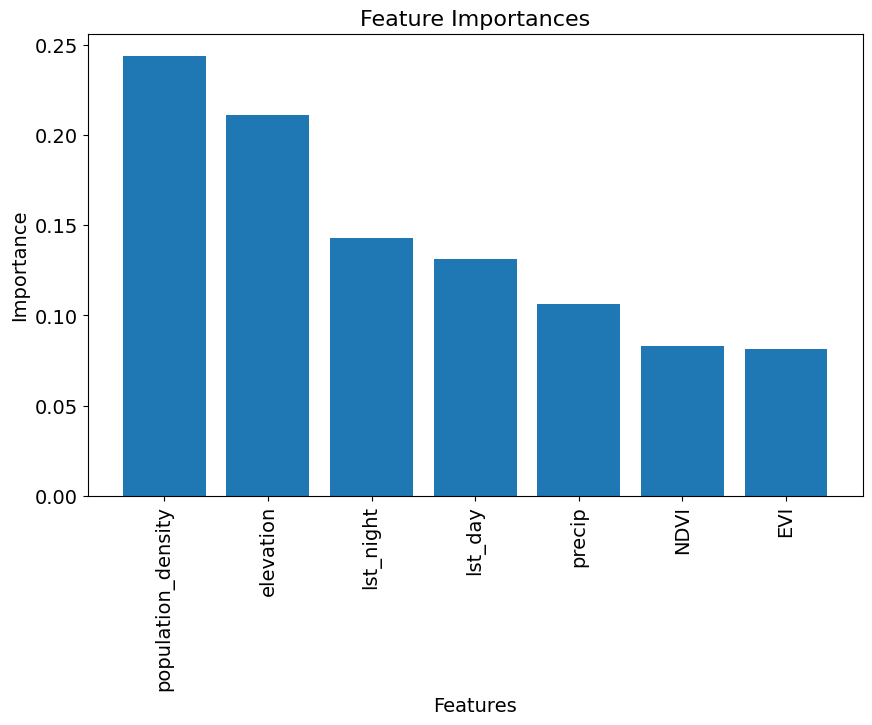

In [ ]:
importances = rf_model.fit(X, y).feature_importances_
print("Feature importances:", importances)
# Plotting the feature importances
feature_names = X.columns
indices = np.argsort(importances)[::-1]  # Sort the features by importance

plt.figure(figsize=(10, 6))
plt.title("Feature Importances",fontsize=16)
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance",fontsize=14)
plt.tick_params(axis='both',which='major',labelsize=14)
#save_path = "/content/drive/MyDrive/ASHISH/RESULT/GLDAS/Feature importance.png"  # Change file format if needed
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()